In [ ]:
from google.colab import files

#Upload multiple files
uploaded = files.upload()

Saving dataset.json to dataset.json
Saving llm_prompt_template_1.json to llm_prompt_template_1.json
Saving llm_prompt_template_2.json to llm_prompt_template_2.json
Saving llm_prompt_template_3.json to llm_prompt_template_3.json


In [ ]:
import json
import pandas as pd


file_path = "dataset.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)
train_data = data.get("train", [])
df = pd.DataFrame(train_data)

label_columns = ["labl", "label", "key"]
df["institution"] = df[label_columns].bfill(axis=1).iloc[:, 0]


df.drop(columns=label_columns, inplace=True)

label_corrections = {
    "oyal Botanic Gardens, Kew": "Royal Botanic Gardens, Kew",
    "oyal College of Physicians of London": "Royal College of Physicians of London",
    "hakespeare Birthplace Trust": "Shakespeare Birthplace Trust",
    "ational Railway Museum": "National Railway Museum",
    "ational Maritime Museum": "National Maritime Museum"
}
df["institution"] = df["institution"].replace(label_corrections)

label_mapping = {
    "National Maritime Museum": "0",
    "National Railway Museum": "1",
    "Royal Botanic Gardens, Kew": "2",
    "Royal College of Physicians of London": "3",
    "Shakespeare Birthplace Trust": "4"
}

df["institution"] = df["institution"].replace(label_mapping)
df["text"] = df["text"].fillna(df["description"]).fillna(df["content"])
df.drop(columns=["description", "content"], inplace=True)
df.drop_duplicates(inplace=True)
print("Unique Institution Labels After Cleaning:")
print(df["institution"].unique())

cleaned_file_path = "/content/cleaned_dataset.csv"
df.to_csv(cleaned_file_path, index=False)
print(f"\nCleaned dataset saved at: {cleaned_file_path}")

Unique Institution Labels After Cleaning:
[1 '2' '4' '1' 0 '3' 4 '0' 3 2]

Cleaned dataset saved at: /content/cleaned_dataset.csv


In [ ]:
import pandas as pd
import spacy
from collections import Counter
import matplotlib.pyplot as plt

file_path = "/content/cleaned_dataset.csv"
df = pd.read_csv(file_path)

#(80-10-10 split)
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)
test_size = len(df) - (train_size + val_size)

df_train = df.iloc[:train_size]
df_val = df.iloc[train_size:train_size + val_size]
df_test = df.iloc[train_size + val_size:]

print(f"Sample counts:")
print(f"- Training Set: {len(df_train)}")
print(f"- Validation Set: {len(df_val)}")
print(f"- Test Set: {len(df_test)}")

total_samples = len(df)
print("\nPercentage splits:")
print(f"- Training: {len(df_train) / total_samples:.2%}")
print(f"- Validation: {len(df_val) / total_samples:.2%}")
print(f"- Test: {len(df_test) / total_samples:.2%}")

print("\nText length analysis (characters):")
for split_name, split_df in zip(["Training", "Validation", "Test"], [df_train, df_val, df_test]):
    text_lengths = split_df["text"].astype(str).apply(len)
    print(f"- {split_name} Set: Min = {text_lengths.min()}, Max = {text_lengths.max()}")

nlp = spacy.load("en_core_web_sm")

def get_top_tokens(texts, top_n=5):
    all_tokens = []
    for text in texts.dropna():
        doc = nlp(text.lower())
        tokens = [token.text for token in doc if token.is_alpha and not token.is_stop]
        all_tokens.extend(tokens)
    return [token for token, _ in Counter(all_tokens).most_common(top_n)]

print("\nMost frequent 5 tokens in each class:")
for institution in df["institution"].unique():
    class_texts = df_train[df_train["institution"] == institution]["text"]
    top_tokens = get_top_tokens(class_texts)
    print(f"- {institution}: {top_tokens}")

df_train.to_csv("/content/train.csv", index=False)
df_val.to_csv("/content/val.csv", index=False)
df_test.to_csv("/content/test.csv", index=False)

Sample counts:
- Training Set: 124
- Validation Set: 15
- Test Set: 16

Percentage splits:
- Training: 80.00%
- Validation: 9.68%
- Test: 10.32%

Text length analysis (characters):
- Training Set: Min = 3, Max = 4263
- Validation Set: Min = 167, Max = 886
- Test Set: Min = 3, Max = 2423

Most frequent 5 tokens in each class:
- 1: ['gb', 'class', 'photographs', 'collection', 'water']
- 2: ['letter', 'papers', 'ridley', 'journal', 'letters']
- 4: ['mr', 'work', 'cross', 'letter', 'paper']
- 0: ['john', 'mr', 'henry', 'sir', 'enclosure']
- 3: ['mr', 'college', 'seal', 'common', 'fellow']


In [ ]:
print("Unique ground truth labels:", df["institution"].unique())
print(df.columns)
print("Unique institution names:", df["institution"].unique())

Unique ground truth labels: [1 2 4 0 3]
Index(['id', 'text', 'institution'], dtype='object')
Unique institution names: [1 2 4 0 3]


In [ ]:
import pandas as pd

cleaned_data_path = "/content/cleaned_dataset.csv"
df_gt = pd.read_csv(cleaned_data_path)

df_gt = df_gt.loc[:, ~df_gt.columns.duplicated()]

if "institution" in df_gt.columns:
    df_gt.rename(columns={"institution": "true_label"}, inplace=True)

df_gt["true_label"] = df_gt["true_label"].astype(str)

print("Unique true labels:", df_gt["true_label"].unique())  # Expected: ['0', '1', '2', '3', '4'

Unique true labels: ['1' '2' '4' '0' '3']


In [ ]:
import json
import pandas as pd

def load_llm_predictions(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        raw_data = json.load(f)

    df_preds = pd.DataFrame(raw_data)

    # Rename 'next_token' to match expected column
    df_preds.rename(columns={"next_token": "predicted_label"}, inplace=True)

    # Ensure predicted_label is string and map invalids to '5'
    valid_labels = {"0", "1", "2", "3", "4"}
    df_preds["predicted_label"] = df_preds["predicted_label"].apply(
        lambda x: str(x) if str(x) in valid_labels else "5"
    )

    return df_preds
preds1 = load_llm_predictions("llm_prompt_template_1.json")
preds2 = load_llm_predictions("llm_prompt_template_2.json")
preds3 = load_llm_predictions("llm_prompt_template_3.json")

In [ ]:
# Ensure 'true_label' column exists before merging
df = df.rename(columns={"institution": "true_label"})

df_eval_1 = df.merge(preds1, on="id", how="inner")
df_eval_2 = df.merge(preds2, on="id", how="inner")
df_eval_3 = df.merge(preds3, on="id", how="inner")

# Remove duplicated columns (if any)
df_eval_1 = df_eval_1.loc[:, ~df_eval_1.columns.duplicated()]
df_eval_2 = df_eval_2.loc[:, ~df_eval_2.columns.duplicated()]
df_eval_3 = df_eval_3.loc[:, ~df_eval_3.columns.duplicated()]

# Verify the Fix
print(df_eval_1.columns)
print(df_eval_1.dtypes)
print("Unique values in true_label:", df_eval_1["true_label"].unique())
print("Unique values in predicted_label:", df_eval_1["predicted_label"].unique())

Index(['id', 'text', 'true_label', 'prompt', 'predicted_label'], dtype='object')
id                 object
text               object
true_label          int64
prompt             object
predicted_label    object
dtype: object
Unique values in true_label: [1 2 4 0 3]
Unique values in predicted_label: ['5']


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def load_llm_predictions(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        llm_data = json.load(f)
    df_preds = pd.DataFrame(llm_data)
    df_preds.rename(columns={"next_token": "predicted_label"}, inplace=True)
    valid_labels = {"0", "1", "2", "3", "4"}
    df_preds["predicted_label"] = df_preds["predicted_label"].apply(lambda x: x if str(x) in valid_labels else "5")

    return df_preds

llm_pred_1 = load_llm_predictions("/content/llm_prompt_template_1.json")
llm_pred_2 = load_llm_predictions("/content/llm_prompt_template_2.json")
llm_pred_3 = load_llm_predictions("/content/llm_prompt_template_3.json")

df_eval_1 = df.merge(llm_pred_1, on="id", how="inner")
df_eval_2 = df.merge(llm_pred_2, on="id", how="inner")
df_eval_3 = df.merge(llm_pred_3, on="id", how="inner")
df_eval_1 = df_eval_1.loc[:, ~df_eval_1.columns.duplicated()]
df_eval_2 = df_eval_2.loc[:, ~df_eval_2.columns.duplicated()]
df_eval_3 = df_eval_3.loc[:, ~df_eval_3.columns.duplicated()]

# Verify the fix
print(df_eval_1.columns)

print(df_eval_1.dtypes)
print("Unique values in true_label:", df_eval_1["true_label"].unique())
print("Unique values in predicted_label:", df_eval_1["predicted_label"].unique())

Index(['id', 'text', 'true_label', 'prompt', 'predicted_label'], dtype='object')
id                 object
text               object
true_label          int64
prompt             object
predicted_label    object
dtype: object
Unique values in true_label: [1 2 4 0 3]
Unique values in predicted_label: ['5']


In [ ]:
def compute_metrics(df, template_name):
    df["true_label"] = df["true_label"].astype(str)
    df["predicted_label"] = df["predicted_label"].astype(str)

    accuracy = accuracy_score(df["true_label"], df["predicted_label"])
    precision = precision_score(df["true_label"], df["predicted_label"], average="macro", zero_division=0)
    recall = recall_score(df["true_label"], df["predicted_label"], average="macro", zero_division=0)
    f1 = f1_score(df["true_label"], df["predicted_label"], average="macro", zero_division=0)

    print(f"\nEvaluation for {template_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall: {recall:.4f}")
    print(f"Macro F1-score: {f1:.4f}")

compute_metrics(df_eval_1, "LLM Prompt Template 1")
compute_metrics(df_eval_2, "LLM Prompt Template 2")
compute_metrics(df_eval_3, "LLM Prompt Template 3")


Evaluation for LLM Prompt Template 1:
Accuracy: 0.0000
Macro Precision: 0.0000
Macro Recall: 0.0000
Macro F1-score: 0.0000

Evaluation for LLM Prompt Template 2:
Accuracy: 0.7600
Macro Precision: 0.7886
Macro Recall: 0.7549
Macro F1-score: 0.7434

Evaluation for LLM Prompt Template 3:
Accuracy: 0.7067
Macro Precision: 0.6743
Macro Recall: 0.5828
Macro F1-score: 0.5846


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
#!pip install datasets

from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load training and validation datasets
train_path = "/content/train.csv"
val_path = "/content/val.csv"

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)

# ✅ Fix NaN values and ensure text is a string
df_train["text"] = df_train["text"].fillna("").astype(str)
df_val["text"] = df_val["text"].fillna("").astype(str)

# ✅ Convert labels to string and map them to integers
df_train["true_label"] = df_train["institution"].astype(str)
df_val["true_label"] = df_val["institution"].astype(str)

label_mapping = {label: idx for idx, label in enumerate(df_train["true_label"].unique())}
df_train["label"] = df_train["true_label"].map(label_mapping)
df_val["label"] = df_val["true_label"].map(label_mapping)

# ✅ Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Define tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# ✅ Convert Pandas DataFrame to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(df_train[["text", "label"]])
val_dataset = Dataset.from_pandas(df_val[["text", "label"]])

# ✅ Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# ✅ Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

In [ ]:
# Check for CUDA availability
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# ✅ Load pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_mapping))
# Move model to CUDA device
model = model.to(device)

# ✅ Define training arguments with CUDA optimizations
training_args = TrainingArguments(
    output_dir="/content/CASE1/results",
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="/content/CASE1/logs",
    logging_steps=50,
    # CUDA-specific settings
    fp16=True,  # Mixed precision training (faster on modern GPUs)
    no_cuda=False,  # Ensure CUDA is used if available
)

# ✅ Define evaluation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro", zero_division=0)
    return {"accuracy": acc, "macro_precision": precision, "macro_recall": recall, "macro_f1": f1}

# ✅ Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# ✅ Train the model
trainer.train()

Using cpu device


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 3046694c (3046694c-university-of-glasgow) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,1.417204,0.466667,0.533333,0.653333,0.479567
2,No log,1.290077,0.533333,0.766667,0.753333,0.666234
3,No log,1.137504,0.533333,0.500000,0.733333,0.566667
4,1.107700,1.101656,0.666667,0.833333,0.806667,0.733333
5,1.107700,0.885294,0.666667,0.666667,0.806667,0.672294
6,1.107700,0.901467,0.666667,0.666667,0.806667,0.672294
7,0.280000,0.957615,0.666667,0.666667,0.806667,0.672294
8,0.280000,0.993353,0.666667,0.666667,0.806667,0.672294


TrainOutput(global_step=128, training_loss=0.5541005004197359, metrics={'train_runtime': 7767.6608, 'train_samples_per_second': 0.128, 'train_steps_per_second': 0.016, 'total_flos': 261013197324288.0, 'train_loss': 0.5541005004197359, 'epoch': 8.0})

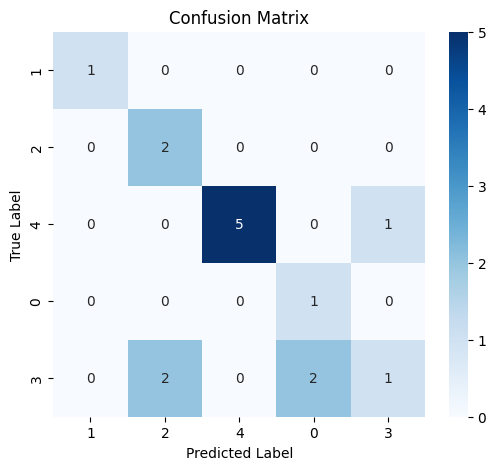

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.50      1.00      0.67         2
           4       1.00      0.83      0.91         6
           0       0.33      1.00      0.50         1
           3       0.50      0.20      0.29         5

    accuracy                           0.67        15
   macro avg       0.67      0.81      0.67        15
weighted avg       0.72      0.67      0.65        15



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Get model predictions
predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = val_dataset["label"]

# ✅ Compute Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# ✅ Plot the Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ✅ Print Classification Report
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=label_mapping.keys()))

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from transformers.integrations import WandbCallback

# ✅ Prepare the training & validation data
train_df = pd.read_csv("/content/train.csv")
val_df = pd.read_csv("/content/val.csv")

# Convert to string and handle NaNs
train_df["text"] = train_df["text"].fillna("").astype(str)
val_df["text"] = val_df["text"].fillna("").astype(str)

# Convert institution to string then map to label IDs
train_df["true_label"] = train_df["institution"].astype(str)
val_df["true_label"] = val_df["institution"].astype(str)

label_mapping = {label: idx for idx, label in enumerate(sorted(train_df["true_label"].unique()))}
train_df["label"] = train_df["true_label"].map(label_mapping)
val_df["label"] = val_df["true_label"].map(label_mapping)

train_ds = Dataset.from_pandas(train_df[["text", "label"]])
val_ds = Dataset.from_pandas(val_df[["text", "label"]])

#  Metric function for trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1
    }
def train_model(base_model_name, output_dir):
    print(f"\n🔧 Training model: {base_model_name}\n")

    tokenizer = AutoTokenizer.from_pretrained(base_model_name)
    model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=5)

    # Tokenize the datasets
    def tokenize_fn(batch):
      return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)


    tokenized_train = train_ds.map(tokenize_fn, batched=True)
    tokenized_val = val_ds.map(tokenize_fn, batched=True)

    tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=8,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=5e-5,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        report_to="none",
        save_total_limit=1,
        logging_dir=f"{output_dir}/logs"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Final evaluation
    preds = trainer.predict(tokenized_val)
    pred_labels = np.argmax(preds.predictions, axis=1)
    print("\n🧾 Classification Report:\n")
    print(classification_report(tokenized_val["label"], pred_labels, target_names=label_mapping.keys()))

models_to_try = [
    #"bert-base-uncased",
    #"roberta-base",
    #"distilbert-base-uncased",
    #"microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract"
]

for model_name in models_to_try:
    output_folder = f"/content/q6_models/{model_name.replace('/', '_')}"
    train_model(model_name, output_folder)


🔧 Training model: microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/124 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,No log,1.386183,0.400000,0.533333,0.673333,0.431429
2,No log,1.354364,0.400000,0.533333,0.673333,0.438095
3,No log,1.276811,0.466667,0.620000,0.706667,0.538095
4,No log,1.338768,0.533333,0.630000,0.740000,0.584762
5,No log,1.427525,0.600000,0.733333,0.773333,0.626667
6,No log,1.067757,0.733333,0.783333,0.840000,0.731429
7,No log,1.157240,0.733333,0.771429,0.840000,0.717949
8,No log,1.210394,0.733333,0.771429,0.840000,0.717949
